Using Xlense from FieldLensing with SphereTransforms for XFields
==========

In [1]:
import FFTW
FFTW.set_num_threads(5)
import FFTransforms
using FFTransforms: r𝕎, 𝕀, ⊗, ordinary_scale

using Spectra
using XFields
using FieldLensing
using SphereTransforms

using SparseArrays
using LinearAlgebra
using LBblocks: @sblock
using PyPlot
using BenchmarkTools

┌ Info: Precompiling SphereTransforms [b2109e22-118d-4f27-a5aa-3a6f7f43afc7]
└ @ Base loading.jl:1323


Set the Xfield transform
----------

In [2]:
trn = @sblock let T=Float64
    spin = 0
    𝕊(T, 4*512, 5*512 - 1, spin)
end

𝕊{Float64}(2048, 2559, 0)

In [3]:
@show Δθarcmin = Δθ′(trn)
@show Δφarcmin = Δφ′(trn);

Δθarcmin = Δθ′(trn) = 5.2734375
Δφarcmin = Δφ′(trn) = 8.440797186400937


In [4]:
l, m = lm(trn);

In [5]:
l

2048×2559 Matrix{Int64}:
    0     1     1     2     2     3  …  1277  1277  1278  1278  1279  1279
    1     2     2     3     3     4     1278  1278  1279  1279  1280  1280
    2     3     3     4     4     5     1279  1279  1280  1280  1281  1281
    3     4     4     5     5     6     1280  1280  1281  1281  1282  1282
    4     5     5     6     6     7     1281  1281  1282  1282  1283  1283
    5     6     6     7     7     8  …  1282  1282  1283  1283  1284  1284
    6     7     7     8     8     9     1283  1283  1284  1284  1285  1285
    7     8     8     9     9    10     1284  1284  1285  1285  1286  1286
    8     9     9    10    10    11     1285  1285  1286  1286  1287  1287
    9    10    10    11    11    12     1286  1286  1287  1287  1288  1288
   10    11    11    12    12    13  …  1287  1287  1288  1288  1289  1289
   11    12    12    13    13    14     1288  1288  1289  1289  1290  1290
   12    13    13    14    14    15     1289  1289  1290  1290  1291  1291


In [6]:
m

2048×2559 Matrix{Int64}:
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6  …  1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6  …  1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6  …  1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277  -1278  1278  -1279  1279
 0  -1  1  -2  2  -3  3  -4  4  -5  5  -6     1277 

Compute the spectral matrices which mimic CMB tempurature and lesing potential
------------------------------

In [7]:
Ct, Cϕ = @sblock let trn
    l, m   = lm(trn)

    cϕl = Spectra.cϕl_approx.(l)

    cTl = Spectra.cTl_approx.(l)
    # cTl = Spectra.cTl_besselj_approx.(l)
    # cTl = Spectra.cTl_matern_cov_approx.(l)
    cTl .*= Spectra.knee.(l; ell=50, alpha=2)
    cTl[l .< 2] .= 0

    cϕl[l .< 2] .= 0

    Ct  = DiagOp(Xfourier(trn, cTl))
    Cϕ  = DiagOp(Xfourier(trn, cϕl))

    Ct, Cϕ
end;

Simulate T and ϕ fields
---------------

In [8]:
T, ϕ = @sblock let trn, Ct, Cϕ
    zTlm = SphereTransforms.white_fourier(trn)
    zϕlm = SphereTransforms.white_fourier(trn)

    T = √Ct * Xfourier(trn, zTlm)
    ϕ = √Cϕ * Xfourier(trn, zϕlm)

    T, ϕ
end;

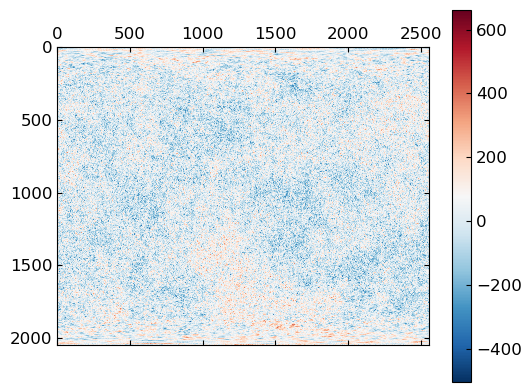

In [9]:
T[:] |> matshow; colorbar();

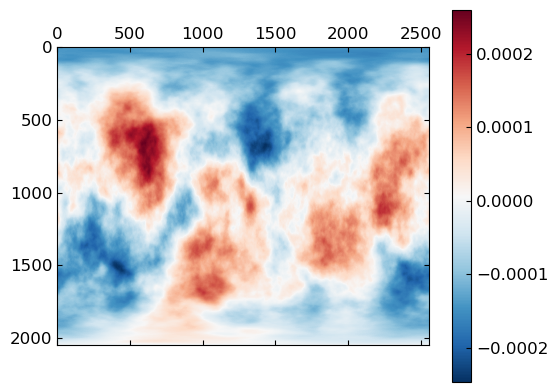

In [10]:
ϕ[:] |> matshow; colorbar();

Equitorial belt with ArrayLense
======================================
To use ArrayLense we just need to define ∇!

In [11]:
struct Nabla!{Tθ,Tφ}
    ∂θ::Tθ
    ∂φᵀ::Tφ
end

function (∇!::Nabla!{Tθ,Tφ})(∇y::NTuple{2,A}, y::NTuple{2,A}) where {Tθ,Tφ,Tf,A<:Array{Tf,2}}
    mul!(∇y[1], ∇!.∂θ, y[1])
    mul!(∇y[2], y[2], ∇!.∂φᵀ)
    ∇y
end

function (∇!::Nabla!{Tθ,Tφ})(∇y::NTuple{2,A}, y::A) where {Tθ,Tφ,Tf,A<:Array{Tf,2}}
    ∇!(∇y, (y,y))
end

function (∇!::Nabla!{Tθ,Tφ})(y::A) where {Tθ,Tφ,Tf,A<:Array{Tf,2}}
    ∇y = (similar(y), similar(y))
    ∇!(∇y, (y,y))
    ∇y
end

Construct ∂θ (action by left mult)

 for healpix on the equitorial belt, cos(θ) is on an even grid.

using SphereTransforms.FastTransforms: chebyshevpoints
cosθ = chebyshevpoints(Float64, trn.nθ; kind=1)

In [12]:
∂θ = @sblock let trn
    onesnθm1 = fill(1,trn.nθ-1)
    ∂θ = (1 / (2Δθ(trn))) * spdiagm(-1 => .-onesnθm1, 1 => onesnθm1)
    ∂θ[1,:] .= 0
    ∂θ[end,:] .= 0
    ∂θ
end

2048×2048 SparseMatrixCSC{Float64,Int64} with 4094 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

Construct ∂φᵀ (action by right mult)

In [13]:
∂φᵀ = @sblock let trn
    onesnφm1 = fill(1,trn.nφ-1)
    ∂φ      = spdiagm(-1 => .-onesnφm1, 1 => onesnφm1)
    # for the periodic boundary conditions
    ∂φ[1,end] = -1
    ∂φ[end,1] =  1
    # now as a right operator
    # (∂φ * f')' == ∂/∂φ f == f * ∂φᵀ
    ∂φᵀ = transpose((1 / (2Δφ(trn))) * ∂φ);
    ∂φᵀ
end

2559×2559 Transpose{Float64,SparseMatrixCSC{Float64,Int64}}:
    0.0    -203.639     0.0       0.0    …     0.0       0.0     203.639
  203.639     0.0    -203.639     0.0          0.0       0.0       0.0
    0.0     203.639     0.0    -203.639        0.0       0.0       0.0
    0.0       0.0     203.639     0.0          0.0       0.0       0.0
    0.0       0.0       0.0     203.639        0.0       0.0       0.0
    0.0       0.0       0.0       0.0    …     0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    0.0       0.0       0.0       0.0    …     0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    0.0       0.0       0.0       0.0          0.0       0.0       0.0
    ⋮         

belt displacement field

In [14]:
### The following leads to some systematics at the edges
vϕbelt = @sblock let trn, ϕ, ∂θ, ∂φᵀ
    θ = pix(trn)[1]
    #sinθ = sin.(θ)
    #cscθ = csc.(θ) # 1/sinθ
    sin⁻²θ = 1 .+ (cot.(θ)).^2 # = cscθ^2

    ϕbelt = ϕ[:]
    ∂θϕ = ∂θ * ϕbelt
    ∂φϕ = ϕbelt * ∂φᵀ
    v1_eθφ_belt = ∂θϕ
    v2_eθφ_belt = ∂φϕ .* sin⁻²θ
    (v1_eθφ_belt, v2_eθφ_belt)
end

([0.0 0.0 … 0.0 0.0; -0.0001359221768156213 -0.00014185956375254577 … -0.00014074262868581794 -0.00013905856692999347; … ; 0.000783492025831747 0.000784705047951451 … 0.0007923558785231933 0.000788344418062649; 0.0 0.0 … 0.0 0.0], [3.9343949228378894 7.43937485416991 … -9.254121581792598 -5.483171634499537; -0.1731392278377655 -0.3785816452120264 … 0.22661103384813738 0.13352694067500495; … ; 0.9550293043268608 1.158252085375216 … 0.41330377208814534 0.5737317138690071; 4.921323992221067 6.190682685085816 … -5.8587064710855605 2.521294194113089])

Now construct the lense

In [15]:
L = @sblock let v=vϕbelt, ∂θ, ∂φᵀ,  ∇! = Nabla!(∂θ, ∂φᵀ), nsteps=16
    t₀ = 0
    t₁ = 1
    FieldLensing.ArrayLense(v, ∇!, t₀, t₁, nsteps)
end;

In [16]:
Tbelt = T[:]
@time lenTbelt = L * Tbelt

 11.421799 seconds (12.47 M allocations: 1.378 GiB, 1.04% gc time)


2048×2559 Matrix{Float64}:
  19444.2          74841.3         …  -105038.0           9847.08
  -2796.08         53955.3             132076.0          54688.4
  -2184.02        211236.0              12593.2           5855.26
  -8532.44        -12351.2              -4923.48         -5243.38
 382819.0             -2.51105e6         9212.59         96226.0
  63271.5          21575.8         …     1474.84           564.369
   1320.46           698.247                5.6917       -1411.78
  -1002.1          -9940.11               263.381         -130.575
    995.372       -16730.5                -61.1872         316.706
     36.3759          12.0436            -126.471            7.34475
     47.5717         -21.3395      …     6367.68          -745.839
     -1.87121        -40.1356             -36.2094         -88.217
    -66.0923        -126.071             -106.162         -116.692
      ⋮                            ⋱                    
     -7.76337e22       4.0049e22           -1.16937

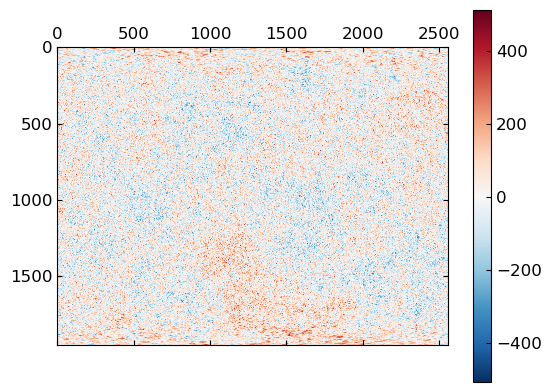

In [17]:
lenTbelt[50:end-50,:] |> matshow; colorbar();

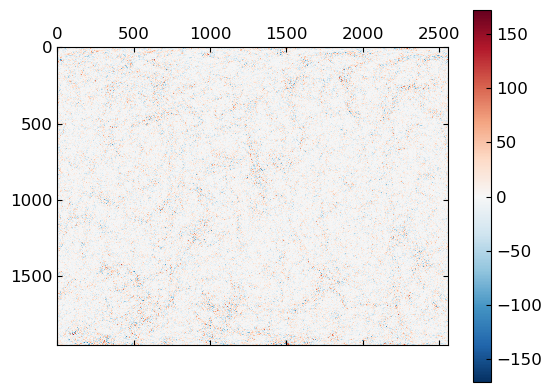

In [18]:
(lenTbelt .- Tbelt)[50:end-50,:] |> matshow; colorbar();

### Inverse Lense

In [19]:
@time Tbelt′ = L \ lenTbelt

  5.068939 seconds (7.94 k allocations: 720.219 MiB, 0.36% gc time)


2048×2559 Matrix{Float64}:
  -84364.8         -12271.6         …   46989.0         -189636.0
  -46799.8         165823.0             18445.2           10602.4
 -659585.0             -8.33236e8       71405.7         -763998.0
      -8.74869e6       -1.192e8             8.79458e7        -4.13454e7
       2.36741e9       -3.94432e9           1.34907e8        -7.75679e8
      -1.86396e7        4.31431e7   …      -1.5826e6          6.7832e6
 -299467.0             -7.86116e7        9212.59         -75590.7
 -756672.0              1.436e6         -2010.5           35139.2
   12444.4         -30067.9               -15.7866        -1334.27
    -194.368          210.348             -73.9098          -83.9838
     -48.5914         -25.3748      …     -61.8918          -35.9177
     -68.5248         -48.2125            -32.6171          -52.6582
     -73.0091         -92.9212           -121.518           -97.3864
       ⋮                            ⋱                   
      -2.70438e59      -3.44

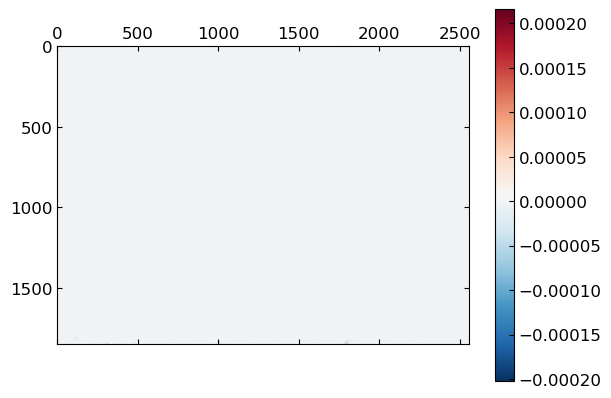

In [20]:
(Tbelt′ .- Tbelt)[100:end-100,:] |> matshow; colorbar();

In [21]:
@benchmark $L * $T

BenchmarkTools.Trial: 
  memory estimate:  879.67 MiB
  allocs estimate:  208
  --------------
  minimum time:     5.718 s (0.06% GC)
  median time:      5.718 s (0.06% GC)
  mean time:        5.718 s (0.06% GC)
  maximum time:     5.718 s (0.06% GC)
  --------------
  samples:          1
  evals/sample:     1

FFT in azimuth with ArrayLense
======================================
To use ArrayLense we just need to define ∇!

In [22]:
struct Nabla!′{Tθ,T1φ,T2φ,T3φ}
    ∂θ::Tθ
    planFFT::T1φ
    ikφ::T2φ
    ak::T3φ
end

function (∇!::Nabla!′{Tθ,T1φ,T2φ,T3φ})(∇y::NTuple{2,A}, y::NTuple{2,A}) where {Tθ,T1φ,T2φ,T3φ,Tf,A<:Array{Tf,2}}
    mul!(∇y[1], ∇!.∂θ, y[1])

    mul!(∇!.ak, ∇!.planFFT.unscaled_forward_transform, y[2])
    @inbounds @. ∇!.ak = ∇!.ak * ∇!.ikφ * ∇!.planFFT.scale_forward * ∇!.planFFT.scale_inverse
    mul!(∇y[2], ∇!.planFFT.unscaled_inverse_transform, ∇!.ak)
    ∇y
end

function (∇!::Nabla!′{Tθ,T1φ,T2φ,T3φ})(∇y::NTuple{2,A}, y::A) where {Tθ,T1φ,T2φ,T3φ,Tf,A<:Array{Tf,2}}
    ∇!(∇y, (y,y))
end

function (∇!::Nabla!′{Tθ,T1φ,T2φ,T3φ})(y::A) where {Tθ,T1φ,T2φ,T3φ,Tf,A<:Array{Tf,2}}
    ∇y = (similar(y), similar(y))
    ∇!(∇y, (y,y))
    ∇y
end

In [23]:
𝕨     = 𝕀(trn.nθ) ⊗ r𝕎(trn.nφ, 2π)
plan𝕨 = FFTransforms.plan(𝕨)
kφ    = FFTransforms.freq(𝕨)[2]' |> Array
ak    = zeros(eltype_out(𝕨), size_out(𝕨))
∇!′   = Nabla!′(∂θ, plan𝕨, im .* kφ, ak)

Nabla!′{SparseMatrixCSC{Float64,Int64},FFTransforms.FFTplan{Float64,2,ComplexF64,Bool,Float64,FFTW.rFFTWPlan{Float64,-1,false,2,Tuple{Int64}},FFTW.rFFTWPlan{ComplexF64,1,false,2,Tuple{Int64}}},Matrix{ComplexF64},Matrix{ComplexF64}}(
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

In [24]:
vϕbelt′ = @sblock let ∇!′, trn, ϕ
    θ = pix(trn)[1]
    sin⁻²θ = 1 .+ (cot.(θ)).^2 # = cscθ^2

    ϕbelt = ϕ[:]
    vϕ′ = ∇!′(ϕbelt)
    (vϕ′[1], vϕ′[2] .* sin⁻²θ)
end

([0.0 0.0 … 0.0 0.0; -0.0001359221768156213 -0.00014185956375254577 … -0.00014074262868581794 -0.00013905856692999347; … ; 0.000783492025831747 0.000784705047951451 … 0.0007923558785231933 0.000788344418062649; 0.0 0.0 … 0.0 0.0], [2.306247386832944 14.871409344673545 … -11.377400136613467 -5.424377499636492; -0.4055741114138329 -0.2648063395552413 … -0.028420419306030884 0.4261007454041542; … ; 1.1388677446266742 1.2733788268307378 … 0.913132794394842 0.21032998691838584; 0.0949889947585583 13.007412951912631 … -7.690100312320795 7.3607935339855315])

Now construct the lense

In [25]:
L′ = @sblock let v=vϕbelt′, ∇!′, nsteps=16
    t₀ = 0
    t₁ = 1
    FieldLensing.ArrayLense(v, ∇!′, t₀, t₁, nsteps)
end;

In [26]:
Tbelt = T[:]
@time lenTbelt′ = L′ * Tbelt

 12.220160 seconds (652.40 k allocations: 752.848 MiB, 0.84% gc time)


2048×2559 Matrix{Float64}:
 -1.503e36    -1.23419e37  -1.61933e38  …   1.2534e37    1.02074e37
  4.63652e42  -2.98002e43   1.87341e41      8.19718e42   7.34366e42
  5.6378e44   -1.70502e44  -1.87759e44      3.66262e44   1.1739e44
 -6.48354e46   1.45336e46  -1.84142e46     -2.65882e46  -8.24631e45
 -1.18296e47  -7.47981e46  -4.26603e46      3.32613e45  -1.3479e46
  5.50438e47   1.59648e46  -7.54035e46  …   1.02877e48   3.80905e46
 -2.57361e47  -2.62996e49  -3.40181e48      2.16969e48   4.00069e48
  2.38379e48   4.00121e48  -3.64452e46     -1.66499e48  -7.9838e47
  1.08342e47   3.54137e47  -9.49041e46      3.08355e47   2.65694e47
  2.38157e45  -3.61504e48  -3.71115e46      4.07684e46   8.62131e46
  1.76635e47  -5.66957e46  -5.5873e46   …   1.36685e49   6.41878e47
 -1.68055e49   2.33074e47   8.35935e46      2.51042e48   1.96912e47
 -1.13209e46   8.38193e44   1.255e46        2.49165e45  -3.38957e45
  ⋮                                     ⋱               
  1.41032e67  -2.54125e67  -3.04121

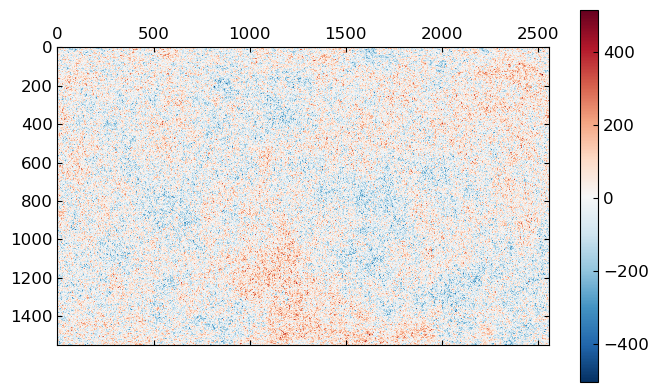

In [27]:
lenTbelt′[250:end-250,:] |> matshow; colorbar();

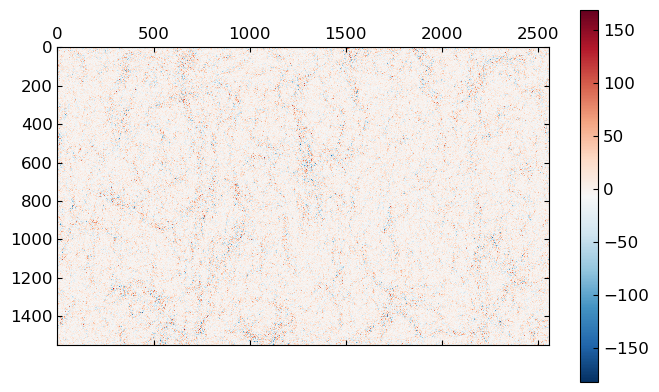

In [28]:
(Tbelt - lenTbelt′)[250:end-250,:] |> matshow; colorbar();

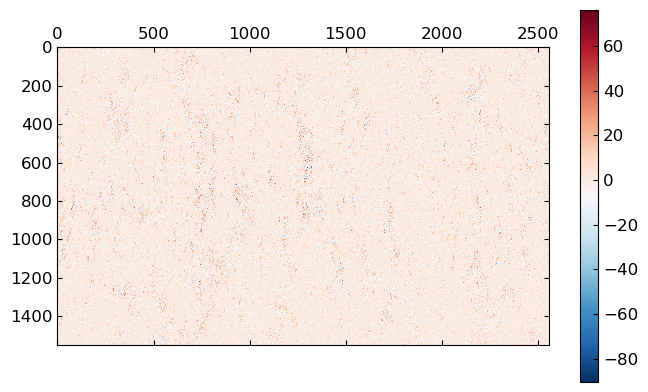

In [29]:
(lenTbelt - lenTbelt′)[250:end-250,:] |> matshow; colorbar();

In [30]:
@time Tbelt′′ = L′ \ lenTbelt′

 11.740660 seconds (14.50 k allocations: 720.765 MiB)


2048×2559 Matrix{Float64}:
 -9.05216e71    3.94507e72    3.36071e72   …   4.89873e72   -2.20385e72
 -9.9333e94    -2.25249e94    1.06577e95      -1.97722e93   -4.10254e94
 -2.19819e94    2.65808e95   -4.30077e95       6.37092e94   -7.87193e93
  5.90797e95    1.86628e96    1.13498e97       1.24762e97   -6.2608e96
  5.69197e99   -4.33263e99    6.01191e99       5.71135e98   -3.09982e99
  2.17456e100   2.72652e99   -7.47993e99   …  -3.77711e100   2.20255e100
  6.06034e99   -1.38458e102   9.89672e101      1.14604e101   1.00042e102
 -2.01218e100   3.10911e100  -4.7662e99       -6.3482e99    -5.6306e99
 -2.9191e98     3.64069e98   -1.28313e98      -3.07487e98    1.39712e98
 -2.00329e97    4.45679e96    9.62566e96       2.12999e98   -4.75646e98
 -1.09271e98   -1.81457e98    2.54688e98   …   1.10912e98   -1.47759e98
 -1.69153e95    7.53475e95   -2.0808e96       -1.34927e96    1.46833e96
  1.50727e93   -5.13288e93    1.39786e94       4.27974e93   -1.34302e93
  ⋮                                  

See how well forward, then backward lensing (with fft in azimuth) does
for recovering the original field

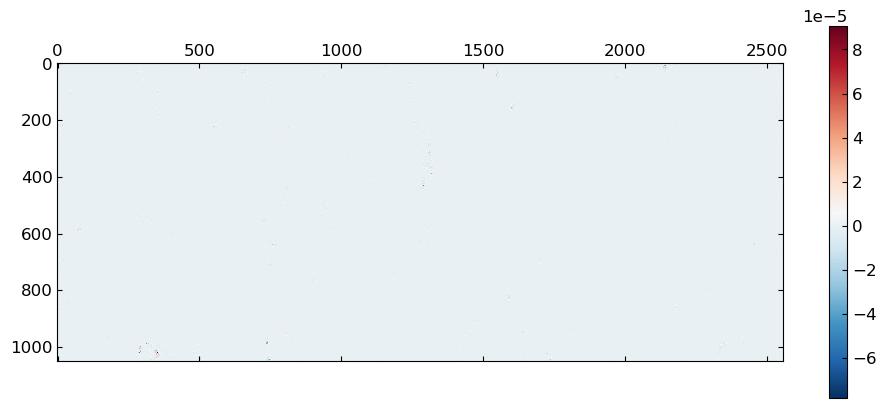

In [31]:
(Tbelt′′ - Tbelt)[500:end-500,:] |> matshow; colorbar();

Compare with how well the map space operator does

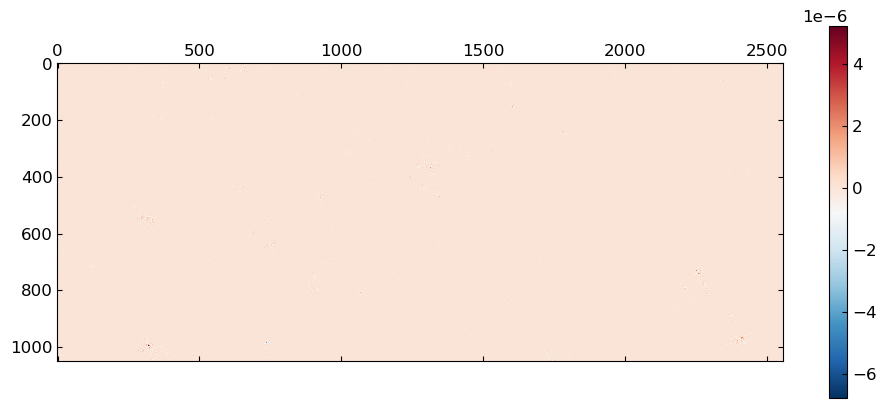

In [32]:
(Tbelt′ - Tbelt)[500:end-500,:] |> matshow; colorbar();